In [1]:
from pathlib import Path
import sys

root = str(Path().resolve().parents[0])
if root not in sys.path:
    sys.path.append(root)

from src.utils import ROOT, DATA_DIR, EXPERIMENTS_DIR, OUTPUT_DIR, DATA_PATHS

for path in [ROOT, DATA_DIR, EXPERIMENTS_DIR, OUTPUT_DIR]:
    if str(path.resolve()) not in sys.path:
        sys.path.append(str(path.resolve()))

print(*sys.path, sep="\n")

from importlib import reload
import src

reload(src)
reload(src.utils)
reload(src.custom_transformers)
reload(src.custom_model_selection)
reload(src.experiment_runner)
reload(src.config_parser)

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/ml_ai_portfolio/notes/example_code/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/ml_ai_portfolio/titanic
/home/ryanwtsai/repos/ml_ai_portfolio/titanic/dataset
/home/ryanwtsai/repos/ml_ai_portfolio/titanic/experiments
/home/ryanwtsai/repos/ml_ai_portfolio/titanic/outputs


<module 'src.config_parser' from '/home/ryanwtsai/repos/ml_ai_portfolio/titanic/src/config_parser.py'>

In [4]:
import pandas as pd
import json

subdir = EXPERIMENTS_DIR / "003b_rfc_cv"

with open(subdir / "ccv_metrics.json", "r") as f:
    metrics = json.load(f)
    print(metrics)
df = pd.read_csv(subdir / "ccv_results.csv")
df.head()

{'accuracy': 0.8361391694725028, 'recall': 0.7309941520467836, 'precision': 0.8223684210526315, 'f1': 0.7739938080495357}


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PredictProba,Prediction,CM,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.158196,0.0,TN,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.970329,1.0,TP,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.351190,0.0,FN,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.993753,1.0,TP,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.133332,0.0,TN,0


In [9]:
from src.utils import load_titanic_data

df_extracted, _, _ = load_titanic_data(load_X_y=False, extracted=True)

df = df_extracted.merge(df[["PredictProba", "Prediction", "CM"]], left_index=True, right_index=True)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Title,Deck,SexPclassAge,PredictProba,Prediction,CM
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,1,Mr,U,"Male, P3, Age>15",0.158196,0.0,TN
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C,1,Mrs,C,Other,0.970329,1.0,TP
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,Miss,U,Other,0.351190,0.0,FN
3,4,1,1,female,35.0,1,0,113803,53.1000,S,1,Mrs,C,Other,0.993753,1.0,TP
4,5,0,3,male,35.0,0,0,373450,8.0500,S,0,Mr,U,"Male, P3, Age>15",0.133332,0.0,TN


In [15]:
import numpy as np
def map_farebins(x):
    bins = np.array([10, 20, 40, 80])
    if x > bins.max():
        return 1000
    return bins[np.argmax(x <= bins)]

def map_agebins(x):
    bins = np.array([5, 15, 30, 40, 50])
    if x > bins.max():
        return 100
    return bins[np.argmax(x <= bins)]

df["AgeBin"] = df["Age"].map(map_agebins)
df["FareBin"] = df["Fare"].map(map_farebins)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

y_true = df["Survived"]
y_pred = df["Prediction"]
cm = confusion_matrix(y_true, y_pred, labels=[0,1])

tab = {"Feature": ["All"],
       "Count": [len(y_true)], 
       "Accuracy": [round(accuracy_score(y_true, y_pred)*100,2)], 
       "Recall": [round(recall_score(y_true, y_pred)*100,2)], 
       "Precision": [round(precision_score(y_true, y_pred)*100,2)], 
       "F1": [round(f1_score(y_true, y_pred)*100,2)],
       "TN": [cm[0,0]], "TP": [cm[1,1]], "FN": [cm[1,0]], "FP": [cm[0,1]]
       }


# tab = {"Feature": [], "Count": [], "Accuracy": [], "Recall": [], "Precision": [], "F1": [],
#        "TN": [], "TP": [], "FN": [], "FP": []}
features = ["Title", "Sex", "Pclass", "AgeBin", "FareBin"]
for feature in features:
    for group in df[feature].value_counts().sort_values(ascending=False).index:
        tab["Feature"].append(feature + "_" + str(group))
        # y_true = df.query("Title == @group").Survived
        # y_pred = df.query("Title == @group").Prediction
        y_true = df.query(f"{feature} == @group").Survived
        y_pred = df.query(f"{feature} == @group").Prediction
        tab["Count"].append(len(y_true))
        tab["Accuracy"].append(round(accuracy_score(y_true, y_pred)*100,2))
        tab["Recall"].append(round(recall_score(y_true, y_pred, zero_division=np.nan)*100,2))
        tab["Precision"].append(round(precision_score(y_true, y_pred, zero_division=np.nan)*100,2))
        tab["F1"].append(round(f1_score(y_true, y_pred, zero_division=np.nan)*100,2))
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        tab["TN"].append(cm[0,0])
        tab["TP"].append(cm[1,1])
        tab["FN"].append(cm[1,0])
        tab["FP"].append(cm[0,1])

scoring_df = pd.DataFrame(tab)

In [22]:
scoring_df.query("Count >= 50").sort_values(by="Accuracy", ascending=True)

,Feature,Count,Accuracy,Recall,Precision,F1,TN,TP,FN,FP
2,Title_Miss,185,77.84,91.54,79.87,85.30,25,119,11,30
9,Sex_female,314,80.57,93.56,82.58,87.73,35,218,15,46
11,Pclass_1,216,81.02,75.74,92.79,83.40,72,103,33,8
13,AgeBin_30,326,81.29,67.52,77.45,72.15,186,79,38,23
10,Pclass_3,491,81.47,57.14,62.96,59.91,332,68,51,40
22,FareBin_80,102,82.35,73.21,93.18,82.00,43,41,15,3
21,FareBin_20,179,83.24,85.53,77.38,81.25,84,65,11,19
20,FareBin_40,200,83.50,74.42,85.33,79.50,103,64,22,11
0,All,891,83.61,73.10,82.24,77.40,495,250,92,54
19,FareBin_10,336,83.63,44.78,62.50,52.17,251,30,37,18


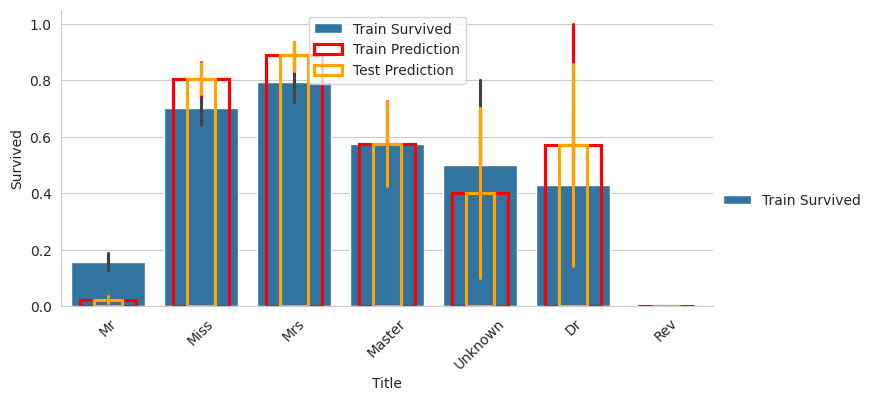

In [12]:
import seaborn as sns
sns.set_style("whitegrid")

g = sns.catplot(df, kind="bar", x="Title", y="Survived", order=df.Title.value_counts().sort_values(ascending=False).index, height=3.7, aspect=2, fill=True, label="Train Survived")
_ = sns.barplot(df, x="Title", y="Prediction", label="Train Prediction", ax=g.ax, color="red", width=0.6, fill=False)
_ = sns.barplot(df, x="Title", y="Prediction", label="Test Prediction", ax=g.ax, color="orange", width=0.3, fill=False)
_ = g.ax.legend()
_ = g.ax.tick_params(axis="x", labelrotation=45)

In [ ]:
df.query("Title == 'Mr'")[["PredictProba", "Survived"]].agg(["count", "mean", "std"])

,PredictProba,Survived
count,517.000000,517.000000
mean,0.160311,0.156673
std,0.118107,0.363844
min,0.040090,0.000000
25%,0.089340,0.000000
50%,0.117284,0.000000
75%,0.174254,0.000000
max,0.602854,1.000000


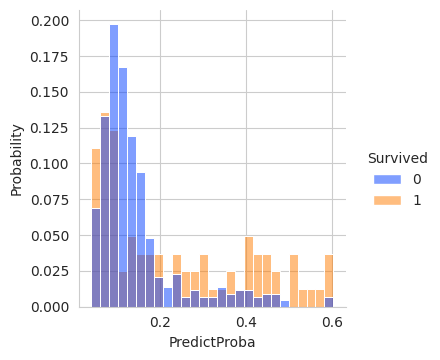

In [31]:
g = sns.displot(df.query("Title == 'Mr'"), kind="hist", x="PredictProba", hue="Survived", palette="bright", height=3.7, stat="probability", common_norm=False)

In [41]:
np.arange(0.1, 0.6, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5])

In [46]:
df_sub = df.query("Title == 'Mr'")
for threshold in np.arange(0.1, 1, 0.1):
    y_pred = df_sub["PredictProba"] >= threshold
    num_correct = sum(y_pred == df_sub["Survived"])
    print(f"{threshold:<30}: {num_correct/len(df_sub)}")

0.1                           : 0.41005802707930367
0.2                           : 0.7794970986460348
0.30000000000000004           : 0.8220502901353965
0.4                           : 0.8413926499032882
0.5                           : 0.8549323017408124
0.6                           : 0.8413926499032882
0.7000000000000001            : 0.8433268858800773
0.8                           : 0.8433268858800773
0.9                           : 0.8433268858800773


In [28]:
df.query("Title == 'Mr' and Survived == 1")[["PredictProba"]].agg(["count", "mean", "std"])

,PredictProba
count,81.000000
mean,0.236737
std,0.171790


In [29]:
df.query("Title == 'Mr' and Survived == 0")[["PredictProba"]].agg(["count", "mean", "std"])

,PredictProba
count,436.000000
mean,0.146113
std,0.099144
